In [2]:
# Customer Feedback Analysis Pipeline

# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, avg, count
from pyspark.sql.types import IntegerType, StringType
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("CustomerFeedbackPipeline") \
    .getOrCreate()

# Step 1: Data Ingestion
# Load CSV file into a Spark DataFrame
feedback_df = spark.read.csv("feedback_data.csv", header=True, inferSchema=True)

# Display the first few rows to understand the data structure
feedback_df.show(5)


+-----------+----------------+------+--------------------+----------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|
+-----------+----------------+------+--------------------+----------+
|     C12345|           Email|     5|The service was g...|2024-11-01|
|     C67890|    Social Media|     4|Good experience o...|2024-10-15|
|     C13579|          Survey|     3|        It was okay.|2024-09-05|
|     C24680|           Email|     2|Could improve pro...|2024-08-20|
|     C11223|    Social Media|     1|Not satisfied wit...|2024-07-14|
+-----------+----------------+------+--------------------+----------+
only showing top 5 rows



In [3]:
# Step 2: Data Cleaning
# Define a function to clean comments
def clean_comment(text):
    if text:
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
        return text.strip()
    else:
        return None

# Register UDF for cleaning comments
clean_comment_udf = udf(clean_comment, StringType())

# Apply the cleaning function to comments and create a new column 'Cleaned_Comment'
feedback_df = feedback_df.withColumn("Cleaned_Comment", clean_comment_udf(col("Comment")))

# Drop rows with missing values in important columns
feedback_df = feedback_df.na.drop(subset=["Customer ID", "Feedback Channel", "Rating", "Cleaned_Comment", "Date"])

# Display cleaned data
feedback_df.show(5)


+-----------+----------------+------+--------------------+----------+--------------------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|     Cleaned_Comment|
+-----------+----------------+------+--------------------+----------+--------------------+
|     C12345|           Email|     5|The service was g...|2024-11-01|The service was g...|
|     C67890|    Social Media|     4|Good experience o...|2024-10-15|Good experience o...|
|     C13579|          Survey|     3|        It was okay.|2024-09-05|         It was okay|
|     C24680|           Email|     2|Could improve pro...|2024-08-20|Could improve pro...|
|     C11223|    Social Media|     1|Not satisfied wit...|2024-07-14|Not satisfied wit...|
+-----------+----------------+------+--------------------+----------+--------------------+
only showing top 5 rows



In [4]:
# Step 3: Sentiment Analysis
# Define a function to classify sentiment based on polarity score from TextBlob
def get_sentiment(text):
    if text:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0.1:
            return "Positive"
        elif polarity < -0.1:
            return "Negative"
        else:
            return "Neutral"
    return "Neutral"

# Register UDF for sentiment analysis
sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis on the cleaned comments
feedback_df = feedback_df.withColumn("Sentiment", sentiment_udf(col("Cleaned_Comment")))

# Show the data with sentiment classification
feedback_df.show(5)


+-----------+----------------+------+--------------------+----------+--------------------+---------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|     Cleaned_Comment|Sentiment|
+-----------+----------------+------+--------------------+----------+--------------------+---------+
|     C12345|           Email|     5|The service was g...|2024-11-01|The service was g...| Positive|
|     C67890|    Social Media|     4|Good experience o...|2024-10-15|Good experience o...| Positive|
|     C13579|          Survey|     3|        It was okay.|2024-09-05|         It was okay| Positive|
|     C24680|           Email|     2|Could improve pro...|2024-08-20|Could improve pro...|  Neutral|
|     C11223|    Social Media|     1|Not satisfied wit...|2024-07-14|Not satisfied wit...| Negative|
+-----------+----------------+------+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [7]:
# Step 4: Trend Analysis
# Analyze feedback trends over time
feedback_trends = feedback_df.groupBy("Date", "Feedback Channel").agg(
    count("Customer ID").alias("Feedback_Count"),
    avg("Rating").alias("Average_Rating")
)

# Determine which channels generate the most negative or positive comments
channel_sentiment = feedback_df.groupBy("Feedback Channel", "Sentiment").count()

# Calculate average ratings per channel
channel_avg_rating = feedback_df.groupBy("Feedback Channel").agg(avg("Rating").alias("Avg_Rating"))

# Show trends data
print("Feedback Trends")
feedback_trends.show(5)
print("\nChannel Sentiment")
channel_sentiment.show(5)
print("\nAverage Rating")
channel_avg_rating.show(5)


Feedback Trends
+----------+----------------+--------------+--------------+
|      Date|Feedback Channel|Feedback_Count|Average_Rating|
+----------+----------------+--------------+--------------+
|2024-06-10|    Social Media|             1|           1.0|
|2024-07-19|          Survey|             1|           5.0|
|2024-06-03|          Survey|             1|           4.0|
|2024-01-04|           Email|             1|           5.0|
|2024-11-02|           Email|             1|           3.0|
+----------+----------------+--------------+--------------+
only showing top 5 rows


Channel Sentiment
+----------------+---------+-----+
|Feedback Channel|Sentiment|count|
+----------------+---------+-----+
|    Social Media| Negative|    8|
|           Email|  Neutral|    9|
|    Social Media|  Neutral|    9|
|           Email| Positive|   20|
|          Survey| Positive|   20|
+----------------+---------+-----+
only showing top 5 rows


Average Rating
+----------------+------------------+
|Feedb

<ipython-input-8-58bf17bb11b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=feedback_df.toPandas(), x="Sentiment", palette="viridis")


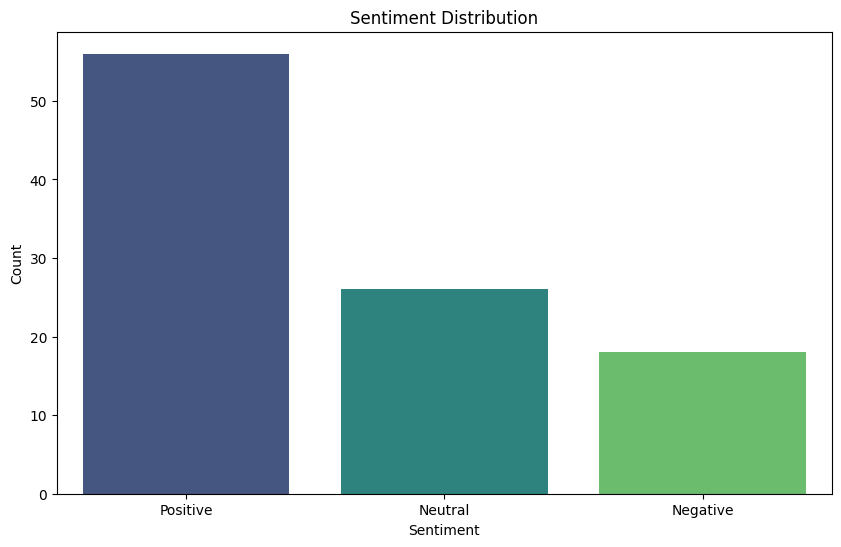

In [8]:
# Step 5: Data Visualization - Sentiment Distribution
# Convert Spark DataFrame to Pandas DataFrame for visualization
feedback_trends_pd = feedback_trends.toPandas()
channel_sentiment_pd = channel_sentiment.toPandas()
channel_avg_rating_pd = channel_avg_rating.toPandas()

# Plot Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=feedback_df.toPandas(), x="Sentiment", palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


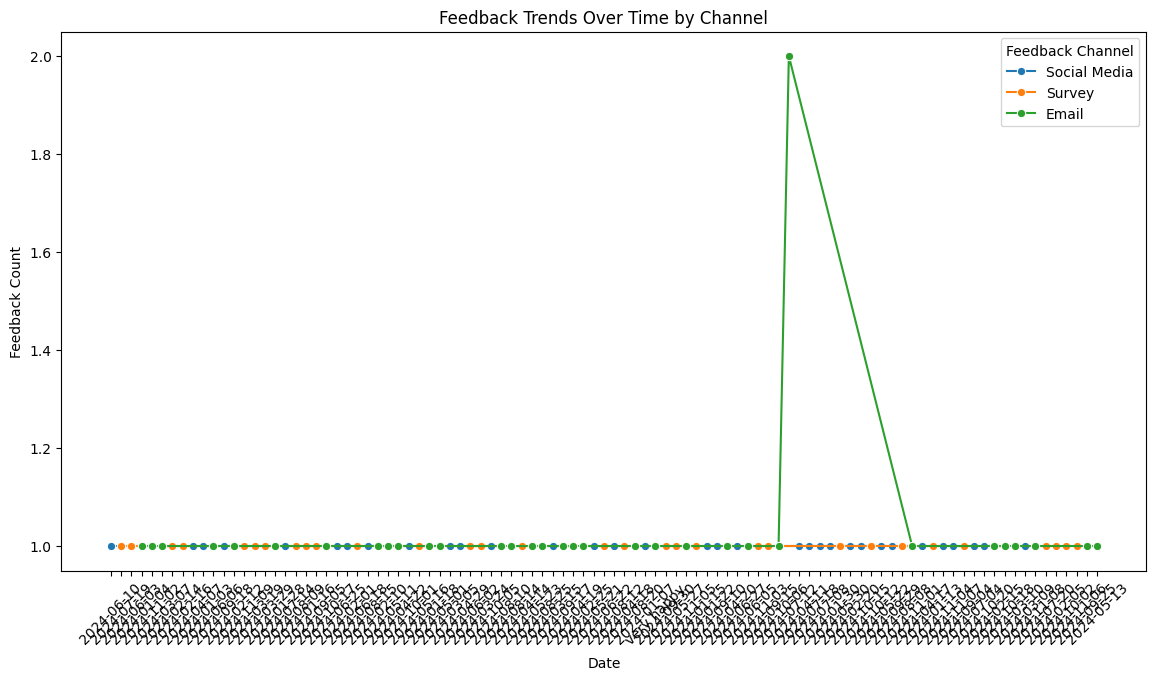

In [9]:
# Step 5: Data Visualization - Feedback Trends Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=feedback_trends_pd, x="Date", y="Feedback_Count", hue="Feedback Channel", marker="o")
plt.title("Feedback Trends Over Time by Channel")
plt.xlabel("Date")
plt.ylabel("Feedback Count")
plt.xticks(rotation=45)
plt.show()


<ipython-input-10-96ebfe7d9c52>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_avg_rating_pd, x="Feedback Channel", y="Avg_Rating", palette="coolwarm")


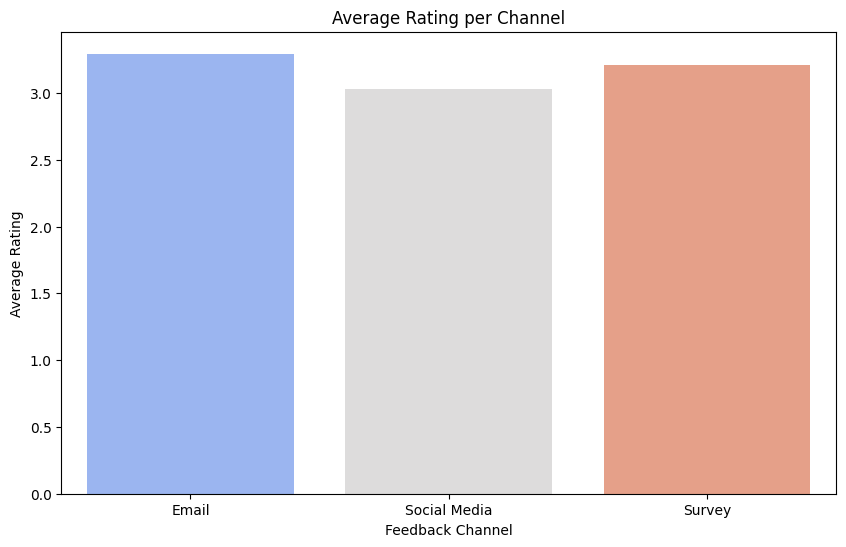

In [10]:
# Step 5: Data Visualization - Average Rating per Channel
plt.figure(figsize=(10, 6))
sns.barplot(data=channel_avg_rating_pd, x="Feedback Channel", y="Avg_Rating", palette="coolwarm")
plt.title("Average Rating per Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Average Rating")
plt.show()


In [11]:
# Step 6: Generate Report with Insights
# Display key insights based on sentiment and trends

print("Insights Report:")
print("1. Channels generating the most negative feedback:")
negative_feedback = channel_sentiment_pd[channel_sentiment_pd["Sentiment"] == "Negative"]
print(negative_feedback.sort_values("count", ascending=False))

print("\n2. Average ratings per channel:")
print(channel_avg_rating_pd.sort_values("Avg_Rating"))

print("\n3. Feedback trends indicate areas of improvement and preferred channels over time.")

spark.stop()


Insights Report:
1. Channels generating the most negative feedback:
  Feedback Channel Sentiment  count
0     Social Media  Negative      8
6           Survey  Negative      5
7            Email  Negative      5

2. Average ratings per channel:
  Feedback Channel  Avg_Rating
1     Social Media    3.030303
2           Survey    3.212121
0            Email    3.294118

3. Feedback trends indicate areas of improvement and preferred channels over time.
